
1.   **Horizontal Embedding  (batch_size,15,512)**
2.   **Image Embedding Finetuned during training**
3.   **Embedding Layer initialized with Normal distribution (finetuned during training)**
4.   **Embedding layer shifted inside main model because in trainer and in custom collate of dataloader it was not getting trained**
5.   **Embedding dim = 512**
6.   **The image embedding is concatenated with each word embedding**
7.   **The conv layers are not of equal dimensions anymore<br>
      first conv layer - (2x512->1024)<br>
      rest conv layers - (512->1024)**
8.   **By doing this the problem of residual connection for multiple  conv layers is resolved**
9. **Increasing the batch size to 10 because batch  size = 1 was leading to too much long training and higher batch sizes were leading to system crashes beacuse of ram overflow**

****








In [1]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
#package for positional encodings  github-> https://github.com/tatp22/multidim-positional-encoding

!pip install positional-encodings

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import math
import sys

In [4]:
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [5]:
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer("You can now install TorchText using pip!")
tokens

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']

In [6]:
import torchtext as tt  # v0.9
import collections
from torchtext.vocab import build_vocab_from_iterator

toker = tt.data.utils.get_tokenizer("basic_english")

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [7]:
device = 'cpu'
if torch.cuda.is_available():  # take over whatever gpus are on the system
    device = torch.cuda.current_device()

In [8]:
# for positional encodings

from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer

# Returns the position encoding only
p_enc_1d_model = PositionalEncoding1D(10)

# Return the inputs with the position encoding added
p_enc_1d_model_sum = Summer(PositionalEncoding1D(10))

x = torch.rand(1,6,10)
penc_no_sum = p_enc_1d_model(x) # penc_no_sum.shape == (1, 6, 10)
penc_sum = p_enc_1d_model_sum(x)
print(penc_no_sum + x == penc_sum) # True

print(penc_sum)

tensor([[[True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True]]])
tensor([[[ 0.8978,  1.6674,  0.4369,  1.5310,  0.6636,  1.4759,  0.2497,
           1.8114,  0.8589,  1.7893],
         [ 1.7806,  1.5039,  0.9146,  1.0378,  0.3441,  1.1626,  0.3453,
           1.5274,  0.8561,  1.8458],
         [ 1.3889, -0.2808,  1.2052,  1.7904,  0.4677,  1.8966,  0.9021,
           1.5786,  0.0330,  1.8321],
         [ 0.3276, -0.7224,  0.9838,  1.2865,  0.3442,  1.2991,  0.3403,
           1.6190,  0.3557,  1.4113],
         [-0.4644,  0.3412,  1.5117,  0.8608,  0.1259,  1.1676,  0.6610,
           1.7779,  0.5159,  1.9044],
         [-0.8039

In [9]:
from datasets import load_dataset

train_dataset = load_dataset("HuggingFaceM4/COCO",split='train')
test_dataset =  load_dataset("HuggingFaceM4/COCO",split='test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for HuggingFaceM4/COCO contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/HuggingFaceM4/COCO.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [10]:
sliced_train_dataset =  train_dataset.select(range(500))
print(len(sliced_train_dataset))

500


In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-07-01 06:10:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-01 06:10:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-01 06:10:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [12]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [13]:
#VGG embeddings which will be finetuned later ----> from convcap vggfeats.py
pretrained_model = models.vgg16(pretrained=True)

class Vgg16Feats(nn.Module):

    def __init__(self):
        super(Vgg16Feats, self).__init__()
        self.features_nopool = nn.Sequential(*list(pretrained_model.features.children())[:-1])
        #print(self.features_nopool)
        self.features_pool = list(pretrained_model.features.children())[-1]
        #print(f"self.features_pool : {self.features_pool}")
        self.classifier = nn.Sequential(*list(pretrained_model.classifier.children())[:-1])
        #print(f"self.classifier : {self.classifier}")

        #self.embed = nn.Linear(input_size, embed_size)   # for turning down the feature vector to embedding dimensions ... transfering it to  the trainer

    def forward(self, x):                                             # y is 4096 dimensional vgg embedding
        x = self.features_nopool(x)
        x_pool = self.features_pool(x)
        x_feat = x_pool.view(x_pool.size(0), -1)
        y = self.classifier(x_feat)
        #y = self.embed(y)

        #print(f"type  of y: {type(y)}")
        return  y

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.2MB/s]


In [14]:
def yield_tokens():
  for i in range(len(sliced_train_dataset)):
    line=sliced_train_dataset[i]['sentences']['raw']
    tokens=toker(line)
    yield tokens

token_generator=yield_tokens()

vocab=build_vocab_from_iterator(token_generator)
vocab.append_token('pad')
vocab.append_token('start')
vocab.append_token('unk')                      #end already exist when taking dataset as 500

for i in range(len(vocab)):
  print(i,vocab.get_itos()[i])

0 a
1 .
2 of
3 in
4 with
5 and
6 the
7 on
8 bathroom
9 is
10 to
11 toilet
12 kitchen
13 white
14 street
15 ,
16 man
17 sink
18 sitting
19 an
20 next
21 shower
22 large
23 small
24 motorcycle
25 two
26 people
27 front
28 room
29 parked
30 building
31 are
32 mirror
33 riding
34 at
35 motorcycles
36 standing
37 up
38 has
39 wall
40 woman
41 bike
42 city
43 picture
44 some
45 that
46 cars
47 down
48 it
49 computer
50 this
51 his
52 person
53 skateboard
54 top
55 view
56 bicycle
57 blue
58 desk
59 road
60 traffic
61 car
62 horses
63 there
64 tub
65 very
66 area
67 bowl
68 by
69 laptop
70 looking
71 lot
72 many
73 other
74 table
75 bathtub
76 cat
77 motor
78 near
79 office
80 over
81 side
82 wearing
83 working
84 black
85 boy
86 driving
87 floor
88 food
89 full
90 green
91 group
92 men
93 orange
94 red
95 several
96 sinks
97 young
98 appliances
99 bunch
100 cabinets
101 close
102 computers
103 curb
104 door
105 filled
106 old
107 park
108 parking
109 police
110 row
111 stove
112 three
113 un

In [15]:
vocab_size=len(vocab)
embedding_dim=100
filepath='/content/glove.6B.100d.txt'

embedding_matrix_vocab = np.zeros((vocab_size,                                            # embedding_matrix_vocab contains the Glove embeddings of the vocabulary words
                                       embedding_dim))

with open(filepath, encoding="utf8") as f:
    for line in f:
        word, *vector = line.split()
        if word=='unk':
            continue
        if vocab.__contains__(word):
            idx = vocab.__getitem__(word)
            embedding_matrix_vocab[idx] = np.array(
                vector, dtype=np.float32)[:embedding_dim]

In [16]:
np.shape(embedding_matrix_vocab)
print(embedding_matrix_vocab[vocab.__getitem__('unk')])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [17]:
#pad_emb_npa = np.zeros((1,embedding_matrix_vocab.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embedding_matrix_vocab,axis=0,keepdims=True)    #embedding for '<unk>' token.

embedding_matrix_vocab[vocab.__getitem__('unk')]=unk_emb_npa
print(embedding_matrix_vocab[vocab.__getitem__('unk')])

[-1.54649255e-01  2.54874021e-01  1.26416009e-01 -1.54341416e-01
  8.67788775e-02  2.32674117e-01 -8.28174200e-02  2.90328873e-01
 -1.80766942e-02  3.97891219e-02  1.24876897e-01 -6.10143749e-02
  2.41499169e-01  1.59347787e-01  1.52479749e-01 -2.60556587e-02
  1.11346901e-01  1.22791192e-01 -2.19469810e-02 -1.69757675e-01
  1.29030495e-01  1.07934019e-01  1.16207433e-01 -1.81458675e-01
  3.08597568e-01 -2.53275897e-02 -2.46480045e-01 -2.31270120e-01
 -1.07880605e-01 -1.16530845e-01  2.81921137e-02  1.45322104e-01
  1.82588274e-02  3.53022597e-02  1.27797537e-01  2.40640482e-01
 -5.19883196e-02  3.46041328e-02  1.85193833e-01 -9.36370613e-02
 -2.96097846e-02 -3.36390224e-01  4.00645060e-02 -2.21827674e-01
 -2.96574838e-02  9.08368885e-02 -8.10369464e-02  2.47024141e-02
  5.55540035e-02 -3.68664015e-01 -1.35916899e-02 -8.66048856e-02
  1.12531815e-03  7.76724569e-01 -1.24784086e-01 -1.46725461e+00
 -1.10084591e-01  6.67930249e-02  1.05995432e+00  2.16526406e-01
 -5.23929982e-02  5.99500

In [18]:
np.shape(embedding_matrix_vocab)

(825, 100)

In [19]:
import torch
my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix_vocab).float())
print(my_embedding_layer.weight.shape)

torch.Size([825, 100])


In [20]:
print(my_embedding_layer(torch.tensor(vocab['unk'])))

tensor([-1.5465e-01,  2.5487e-01,  1.2642e-01, -1.5434e-01,  8.6779e-02,
         2.3267e-01, -8.2817e-02,  2.9033e-01, -1.8077e-02,  3.9789e-02,
         1.2488e-01, -6.1014e-02,  2.4150e-01,  1.5935e-01,  1.5248e-01,
        -2.6056e-02,  1.1135e-01,  1.2279e-01, -2.1947e-02, -1.6976e-01,
         1.2903e-01,  1.0793e-01,  1.1621e-01, -1.8146e-01,  3.0860e-01,
        -2.5328e-02, -2.4648e-01, -2.3127e-01, -1.0788e-01, -1.1653e-01,
         2.8192e-02,  1.4532e-01,  1.8259e-02,  3.5302e-02,  1.2780e-01,
         2.4064e-01, -5.1988e-02,  3.4604e-02,  1.8519e-01, -9.3637e-02,
        -2.9610e-02, -3.3639e-01,  4.0065e-02, -2.2183e-01, -2.9657e-02,
         9.0837e-02, -8.1037e-02,  2.4702e-02,  5.5554e-02, -3.6866e-01,
        -1.3592e-02, -8.6605e-02,  1.1253e-03,  7.7672e-01, -1.2478e-01,
        -1.4673e+00, -1.1008e-01,  6.6793e-02,  1.0600e+00,  2.1653e-01,
        -5.2393e-02,  5.9950e-01, -3.5295e-02,  2.7518e-01,  3.4237e-01,
        -3.5289e-03,  3.9784e-01, -6.6585e-02,  4.4

In [21]:
len_list=list()
sum=0
print(f'sliced_train_dataset size: {len(sliced_train_dataset)}')

for i in range(len(sliced_train_dataset)):
  sentence=sliced_train_dataset[i]['sentences']['raw']
  split_sentence=sentence.split(" ")
  len_list.append(len(split_sentence))
  sum+=len(split_sentence)

avg_length=sum/len(sliced_train_dataset)

print(avg_length)
print(len_list)

sliced_train_dataset size: 500
10.426
[12, 8, 11, 10, 13, 10, 11, 9, 9, 11, 13, 9, 9, 9, 9, 8, 12, 9, 9, 21, 8, 14, 9, 11, 9, 11, 10, 9, 14, 11, 9, 9, 8, 11, 10, 9, 11, 14, 8, 11, 12, 11, 11, 9, 11, 12, 12, 8, 9, 8, 8, 9, 10, 8, 13, 9, 20, 13, 10, 10, 9, 12, 10, 12, 8, 12, 9, 11, 10, 8, 8, 9, 9, 9, 9, 13, 9, 10, 8, 11, 14, 12, 12, 11, 12, 8, 10, 8, 12, 11, 10, 25, 11, 8, 14, 11, 9, 8, 12, 8, 9, 9, 10, 9, 8, 10, 10, 11, 9, 10, 9, 11, 10, 18, 13, 11, 11, 11, 16, 10, 13, 9, 11, 10, 14, 11, 12, 12, 10, 10, 9, 11, 10, 8, 9, 9, 8, 10, 8, 9, 8, 11, 9, 9, 11, 10, 12, 9, 13, 9, 10, 10, 8, 18, 8, 10, 9, 8, 9, 14, 15, 11, 10, 13, 17, 11, 10, 10, 10, 9, 12, 8, 11, 9, 13, 11, 12, 9, 11, 9, 14, 11, 10, 8, 8, 10, 8, 9, 12, 13, 10, 8, 9, 10, 10, 10, 10, 10, 11, 9, 8, 10, 8, 8, 9, 8, 12, 11, 10, 12, 11, 11, 10, 10, 12, 10, 9, 9, 10, 8, 11, 11, 11, 8, 8, 9, 8, 10, 10, 9, 9, 9, 8, 8, 12, 12, 9, 11, 11, 10, 8, 9, 8, 8, 10, 9, 11, 11, 11, 8, 10, 8, 11, 8, 9, 10, 10, 11, 9, 8, 9, 14, 10, 14, 11, 9, 11, 12, 

In [22]:
avg_length=round(avg_length)
print(avg_length)

10


In [23]:
standardise_len=13

In [24]:
for i in range(len(sliced_train_dataset)):
  sentence=sliced_train_dataset[i]['sentences']['raw']
  sentence_split=sentence.split()
  print(i," ",len(sentence_split)," ",sentence)
  if(len(sentence_split)<standardise_len):
    print(sentence)

  else:
    print(" ".join(sentence_split[0:standardise_len]))

0   11   A woman wearing a net on her head cutting a cake. 
A woman wearing a net on her head cutting a cake. 
1   8   A woman cutting a large white sheet cake.
A woman cutting a large white sheet cake.
2   11   A woman wearing a hair net cutting a large sheet cake.
A woman wearing a hair net cutting a large sheet cake.
3   10   there is a woman that is cutting a white cake
there is a woman that is cutting a white cake
4   12   A woman marking a cake with the back of a chef's knife. 
A woman marking a cake with the back of a chef's knife. 
5   10   A young boy standing in front of a computer keyboard.
A young boy standing in front of a computer keyboard.
6   11   a little boy wearing headphones and looking at a computer monitor
a little boy wearing headphones and looking at a computer monitor
7   9   He is listening intently to the computer at school.
He is listening intently to the computer at school.
8   9   A young boy stares up at the computer monitor.
A young boy stares up at the 

In [25]:
def standardiseAvgLength(example):
  sentence=example['sentences']['raw']
  sentence=sentence.replace('.','')
  sentence=sentence.replace(',','')
  sentence=sentence.replace("'","")
  sentence=sentence.lower()
  split_sentence=sentence.split()
  n=standardise_len-len(split_sentence)
  if(n>0):
    sentence='start '+sentence+' end'
    sentence=sentence + ' pad '*(n)
  else:
    sentence=" ".join(split_sentence[0:standardise_len])
    sentence='start '+sentence+' end'
  #print(sentence)
  example['sentences']['raw']=sentence
  print(example['sentences']['raw'])
  return example

In [26]:
processed_train_dataset=sliced_train_dataset.map(standardiseAvgLength)
#test_dataset=test_dataset.map(standardiseAvgLength)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

start a woman wearing a net on her head cutting a cake  end pad  pad 
start a woman cutting a large white sheet cake end pad  pad  pad  pad  pad 
start a woman wearing a hair net cutting a large sheet cake end pad  pad 
start there is a woman that is cutting a white cake end pad  pad  pad 
start a woman marking a cake with the back of a chefs knife  end pad 
start a young boy standing in front of a computer keyboard end pad  pad  pad 
start a little boy wearing headphones and looking at a computer monitor end pad  pad 
start he is listening intently to the computer at school end pad  pad  pad  pad 
start a young boy stares up at the computer monitor end pad  pad  pad  pad 
start a young kid with head phones on using a computer  end pad  pad  pad 
start a boy wearing headphones using one computer in a long row of computers end
start a little boy with earphones on listening to something end pad  pad  pad  pad 
start a group of people sitting at desk using computers end pad  pad  pad  pad

In [27]:
for  i in range(len(processed_train_dataset)):
  sentence=processed_train_dataset[i]['sentences']['raw']
  print(sentence,len(sentence.split()))

start a woman wearing a net on her head cutting a cake  end pad  pad  15
start a woman cutting a large white sheet cake end pad  pad  pad  pad  pad  15
start a woman wearing a hair net cutting a large sheet cake end pad  pad  15
start there is a woman that is cutting a white cake end pad  pad  pad  15
start a woman marking a cake with the back of a chefs knife  end pad  15
start a young boy standing in front of a computer keyboard end pad  pad  pad  15
start a little boy wearing headphones and looking at a computer monitor end pad  pad  15
start he is listening intently to the computer at school end pad  pad  pad  pad  15
start a young boy stares up at the computer monitor end pad  pad  pad  pad  15
start a young kid with head phones on using a computer  end pad  pad  pad  15
start a boy wearing headphones using one computer in a long row of computers end 15
start a little boy with earphones on listening to something end pad  pad  pad  pad  15
start a group of people sitting at desk us

In [28]:

embed_len = 100
vocab_len = my_embedding_layer.weight.shape[0]
#vocab_len = np.shape(embedding_matrix_vocab)[0]
img_input_len = 4096
input_len = 1700 # for horizontal stacking
#input_len = 100 # for vertical stacking
cap_len = 15
max_epochs = 100

 *Creating an embedding layer initialising it with glove embeddings to be finetuned later*

In [29]:

def CustomEmbedding():
  my_embeddings = torch.nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix_vocab).float())
  return my_embeddings

In [30]:
my_embeddings = CustomEmbedding()                         #declaring our custom embedding layer
print(my_embeddings.weight.shape)

torch.Size([825, 100])


In [31]:
class CustomCocoDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        #self.transform = transform
        self.transform = T.Compose([
                      T.Resize((224, 224)),
                      T.ToTensor(),
                      #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        #image = Image.fromarray(example["image"])
        image=self.dataset[idx]['image']
        caption=self.dataset[idx]['sentences']['raw']

        '''
        if self.transform:
            image = self.transform(image)
        '''
        image=self.transform(image)


        return image,caption

*When we are processing the caption embeddings if the word embeddings are not finetuned later (like using only Glove Embeddings) then using list in the Custom Collate function is fine but if we intend to further finetune word embeddings later the we can't use list because turns out pytorch does not register list as parametre in nn.module and hence could not use autograd on it so we need to use ParametreList in its place which again does not support torch.cat so we have to do it manually*

In [32]:
#detaching the image embedding process from custom collate to finetune the image encoder at each epoch during training
##this custom collate returns just the transformed image which will be encoded later on (in the  train  func) so that it can be encoded with the recent trained version of vgg16
###this collate uses only Glove embeddings which  are finetuned during training
def NewcustomCollate2(batch):


    images = torch.stack([item[0] for item in batch], dim=0)
    images = torch.tensor(images).to(device)


    captions=[item[1] for item in batch]


    PositionalEncodingModel=Summer(PositionalEncoding1D(100))

    caption_embeddings_list=list()
    caption_one_hot_embeddings_list=list()
    percaption_onehot_embeddings_list=list()
    for  caption in captions:
      #embeddings = nn.ParameterList()
      words=caption.split()
      caption_one_hot_embeddings_list=list()
      for word in caption.split():
        idx = torch.tensor([vocab[word]], dtype=torch.long)
        one_hot_vector = F.one_hot(torch.tensor(idx),num_classes=vocab_len)
        caption_one_hot_embeddings_list.append(one_hot_vector)
        #embed = my_embeddings(idx)
        #embeddings.append(torch.FloatTensor(embed))

        #single_caption_embeddings=torch.cat([embeddings[0]],dim=1)
        #for i in range(1,len(embeddings)):
         #   single_caption_embeddings = torch.cat([single_caption_embeddings,embeddings[i]],dim=1)

      #caption_embeddings_list.append(single_caption_embeddings)
      percaption_onehot_embeddings = torch.cat(caption_one_hot_embeddings_list,dim=0)
      percaption_onehot_embeddings_list.append(percaption_onehot_embeddings)

    #caption_embeddings = torch.cat(caption_embeddings_list,dim=0)
    caption_onehot_embeddings=torch.stack(percaption_onehot_embeddings_list,dim=0)
    #caption_embeddings= torch.reshape(caption_embeddings,(1,15,-1))
    #caption_embeddings = PositionalEncodingModel(caption_embeddings)        #(1,15,100)
    #caption_embeddings = torch.reshape(caption_embeddings,(1,-1))           #(1,1500)


    #return caption_embeddings,caption_onehot_embeddings,images,captions
    return caption_onehot_embeddings,captions,images

In [33]:
#detaching the image embedding process from custom collate to finetune the image encoder at each epoch during training
##this custom collate returns just the transformed image which will be encoded later on (in the  train  func) so that it can be encoded with the recent trained version of vgg16
###this custom collate uses trainable word embeddings

def NewcustomCollate(batch):

    #encoder = CNN(embed_size = 512).to(device)
    #encoder = Vgg16Feats(4096,100)

    #PositionalEncodingModel=Summer(PositionalEncoding1D(100))   #for adding positional encoding
    #images = torch.stack([item[0] for item in batch], dim=0)
    captions=[item[1] for item in batch]

    #images = torch.tensor(images).to(device)
    #captions = torch.tensor(captions).to(device)

    #featuresI=encoder(images)                        #VGGNet embedding for the image
    #featuresI = torch.tensor(featuresI)

    caption_embeddings_list=list()
    caption_one_hot_embeddings_list=list()
    percaption_onehot_embeddings_list=list()
    for  caption in captions:
      embeddings=list()
      words=caption.split()
      #idx=vocab.__getitem__(words[0])
      #one_hot_vector=F.one_hot(torch.tensor(idx),num_classes=vocab_len)
      #caption_one_hot_embeddings_list.append(one_hot_vector)
      caption_one_hot_embeddings_list=list()
      for word in caption.split():
        idx=vocab.__getitem__(word)
        one_hot_vector=F.one_hot(torch.tensor(idx),num_classes=vocab_len)
        caption_one_hot_embeddings_list.append(one_hot_vector)
        #embeds=embedding_matrix_vocab_tensor(torch.tensor(idx)) #idx must be a tensor not an int
        embeds=embedding_matrix_vocab[idx]
        #positional_embeds=PositionalEncodingModel(embeds)
        embeddings.append(torch.FloatTensor(embeds))
      single_caption_embeddings=torch.stack(embeddings)
      caption_embeddings_list.append(single_caption_embeddings)
      percaption_onehot_embeddings=torch.stack(caption_one_hot_embeddings_list)
      percaption_onehot_embeddings_list.append(percaption_onehot_embeddings)
    #print("caption_embeddings_list size: ",len(caption_embeddings_list))
    caption_embeddings=torch.stack(caption_embeddings_list)
    caption_onehot_embeddings=torch.stack(percaption_onehot_embeddings_list,dim=0)
    #print("caption_embeddings size: ",caption_embeddings.size())


    #return caption_embeddings,caption_onehot_embeddings,images,captions
    return caption_embeddings,caption_onehot_embeddings,captions

In [34]:
class CustomDataLoading(Dataset):

  def __init__(self,dataset,batch_size,num_workers):
    self.dataset=dataset
    self.batch_size=batch_size
    self.num_workers=num_workers

  def loading_data(self):
    # Define data transformations
    transform = T.Compose([
      T.Resize((224, 224)),
      T.ToTensor(),
      #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])


    custom_dataset = CustomCocoDataset(self.dataset)

# Specify batch size and create a data loader
    data_loader = DataLoader(custom_dataset,shuffle=False, pin_memory=False,batch_size=self.batch_size,num_workers=self.num_workers,collate_fn=NewcustomCollate2,drop_last=True)

    return data_loader

In [35]:
train_loader=enumerate(CustomDataLoading(processed_train_dataset,batch_size=16,num_workers=0).loading_data())

In [36]:
idx,(caption_onehot_embeddings,captions,images) = next(iter(train_loader))

<ipython-input-32-b1174a3fd3a2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
<ipython-input-32-b1174a3fd3a2>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_vector = F.one_hot(torch.tensor(idx),num_classes=vocab_len)


In [37]:
print(idx)
#print(caption_embeddings.size())
print(caption_onehot_embeddings.size())
print(images.size())
print(captions)

0
torch.Size([16, 15, 825])
torch.Size([16, 3, 224, 224])
['start a woman wearing a net on her head cutting a cake  end pad  pad ', 'start a woman cutting a large white sheet cake end pad  pad  pad  pad  pad ', 'start a woman wearing a hair net cutting a large sheet cake end pad  pad ', 'start there is a woman that is cutting a white cake end pad  pad  pad ', 'start a woman marking a cake with the back of a chefs knife  end pad ', 'start a young boy standing in front of a computer keyboard end pad  pad  pad ', 'start a little boy wearing headphones and looking at a computer monitor end pad  pad ', 'start he is listening intently to the computer at school end pad  pad  pad  pad ', 'start a young boy stares up at the computer monitor end pad  pad  pad  pad ', 'start a young kid with head phones on using a computer  end pad  pad  pad ', 'start a boy wearing headphones using one computer in a long row of computers end', 'start a little boy with earphones on listening to something end pad  

In [38]:
caption_onehot_embeddings_slice = caption_onehot_embeddings[:,5,:]
print(caption_onehot_embeddings_slice.size())

torch.Size([16, 825])


# **MODEL**

In [48]:
# Parametres
# already defined above
batch_size = 10
embed_len = 512
#vocab_len = 290
input_len = 1700 # for horizontal stacking
#input_len = 4100
#input_len = 100 # for vertical stacking
cap_len = 15
max_tokens = 16
max_epochs = 10
learning_rate = 4e-6
#learning_rate = 1e-4
lr_step_size = 10
finetune_after = 5

In [40]:
device = 'cpu'
if torch.cuda.is_available():  # take over whatever gpus are on the system
    device = torch.cuda.current_device()

In [41]:
st_idx=vocab.__getitem__('start')

In [42]:
def Linear(in_features, out_features, dropout=0.):
    m = nn.Linear(in_features, out_features)
    m.weight.data.normal_(mean=0, std=math.sqrt((1 - dropout) / in_features))
    m.bias.data.zero_()
    return nn.utils.weight_norm(m)

def Conv1d(self,in_channels, out_channels,kernel_size,pad, dropout=0):
      m = nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad)
      std = math.sqrt((4 * (1.0 - dropout)) / (kernel_size * in_channels))
      m.weight.data.normal_(mean=0, std=std)
      m.bias.data.zero_()
      return nn.utils.weight_norm(m)

*We can't have the trainable embedding layer defined in the trainer or somewhere outside the main model because then it will not get trained*

In [43]:
class ConvEmbGenerator(nn.Module):

    def Conv1d(self,in_channels, out_channels,kernel_size,pad,dropout=0):
        m = nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad)
        std = math.sqrt((4 * (1.0 - dropout)) / (kernel_size * in_channels))
        m.weight.data.normal_(mean=0, std=std)
        m.bias.data.zero_()
        return nn.utils.weight_norm(m)

    def Embedding(self,num_embeddings, embedding_dim, padding_idx=824):
        m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=824)
        m.weight.data.normal_(0, 0.1)
        return m

    def Linear(self,in_features, out_features, dropout=0.):
        m = nn.Linear(in_features, out_features)
        m.weight.data.normal_(mean=0, std=math.sqrt((1 - dropout) / in_features))
        m.bias.data.zero_()
        return nn.utils.weight_norm(m)


    def __init__(self,embedding_matrix_vocab,num_layers=3,nfeats=embed_len,dropout=0.1):
        super(ConvEmbGenerator, self).__init__()
        self.kernel_size = 5
        #self.kernel_size = 1
        #self.pad = self.kernel_size-1
        self.nin = 2*embed_len
        self.nout= embed_len
        self.pad = 2
        self.n_layers = num_layers
        self.nimgfeats = 4096
        self.nfeats = nfeats
        self.dropout = dropout

        self.device = 'cpu'
        if torch.cuda.is_available():  # take over whatever gpus are on the system
          self.device = torch.cuda.current_device()

        self.embeds = self.Embedding(vocab_len,512)                                       # this one is an embedding layer initialised with normal distribution
        #self.embeds = torch.nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix_vocab).float())    # this embedding layer is initialised with glove embeddings
        self.emb1 = self.Linear(self.nfeats,self.nfeats,dropout=self.dropout)
        self.imgproj1 = self.Linear(self.nimgfeats,embed_len,dropout=self.dropout)             # for residual first projecting 4096->512
        self.resproj = self.Linear(self.nin,self.nout,dropout=self.dropout)                # residual projection: (2x512 -> 512)
        self.vocabproj = self.Linear(max_tokens*self.nfeats,vocab_len,dropout=self.dropout)           # vocabulary projection: (16*512 -> vocab_len (825))
        self.convs = nn.ModuleList()

        for i in range(self.n_layers):

          self.convs.append(self.Conv1d(self.nin,2*self.nout,self.kernel_size,self.pad,self.dropout))             # first conv layer: (1024 -> 1024)
          self.nin = self.nout                                                                                    # rest conv layers: (512 -> 1024)

    def GetEmbeddings(self,id,captions):
        PositionalEncodingModel=Summer(PositionalEncoding1D(512))

        caption_embeddings_list=list()
        caption_one_hot_embeddings_list=list()
        percaption_onehot_embeddings_list=list()
        last_word_embeddings_list = list()

        #embeddings = embeddings.to(device=self.device)
        for caption in captions:
            words=caption.split()
            embeddings = nn.ParameterList()
            caption_one_hot_embeddings_list=list()
            for word in words:
              idx = torch.tensor([vocab[word]], dtype=torch.long)
              #print(f'idx device: {idx.get_device()}')
              one_hot_vector=F.one_hot(torch.tensor(idx),num_classes=vocab_len)
              caption_one_hot_embeddings_list.append(one_hot_vector)
              embed=self.embeds(idx.to(device=self.device))
              embed=embed.cpu()
              #print(f'embed device: {embed.get_device()}')
              embeddings.append(torch.FloatTensor(embed))

            single_caption_embeddings=torch.cat([embeddings[0]],dim=1)
            for i in range(1,len(embeddings)):
                single_caption_embeddings=torch.cat([single_caption_embeddings,embeddings[i]],dim=0)                    # (15,512)

            if idx==0:
                start=torch.tensor([st_idx],dtype=torch.long)
                last_word_emb = self.embeds(start)[None,:]

            else:
                ith_word = torch.tensor(vocab[words[id-1]],dtype=torch.long,device=self.device)
                #print(f'ith word device: {ith_word.get_device()}')
                last_word_emb = self.embeds(ith_word)[None,None,:]


            #print(f'single_caption_embeddings: {single_caption_embeddings.size()}')
            last_word_embeddings_list.append(last_word_emb)
            caption_embeddings_list.append(single_caption_embeddings)
            #percaption_onehot_embeddings=torch.cat(caption_one_hot_embeddings_list,dim=0)
            #percaption_onehot_embeddings_list.append(percaption_onehot_embeddings)



        last_word_embeddings = torch.stack(last_word_embeddings_list,dim=0).squeeze().unsqueeze(1)              #(batch_size,1,512)
        caption_embeddings = torch.stack(caption_embeddings_list,dim=0)                                         #(batch_size,15,512)
        #print(f'last_word_embeddings_list size: {len(last_word_embeddings_list)}')
        #print(f'caption_embeddings size: {caption_embeddings.size()}')
        #print(f'last_word_embeddings size: {last_word_embeddings.size()}')
        #caption_onehot_embeddings = torch.cat(percaption_onehot_embeddings_list,dim=0)
        #print(f'caption_embeddings size: {caption_embeddings.size()}')
        #caption_embeddings = torch.reshape(caption_embeddings,(-1,15,-1))
        caption_embeddings = PositionalEncodingModel(caption_embeddings)                                        #(batch_size,16,512)

        caption_embeddings =  caption_embeddings.to(device=self.device)
        caption_embeddings = torch.cat([caption_embeddings,last_word_embeddings],dim=1)
        #print(f'caption_embeddings size: {caption_embeddings.size()}')

        return caption_embeddings


    def CustomCrossEntropy(self,out,targets):
      CustomLoss=0
      print("in loss out shape: ",out.size())
      print("in loss target shape: ",targets.size())

      '''
      for i in range(out.size()[0]):
        #print(f'{i} : out[i]: {out[i:]} targets[i]: {targets[i:]} loss_i: {F.cross_entropy(out[i,:], targets[i,:].float())}')
        CustomLoss+=F.cross_entropy(out[i,:], targets[i,:].float())

      CustomLoss=(CustomLoss)/out.size()[0]
      '''

      out1 = torch.squeeze(out)              #for removing the dummy axis
      CustomLoss = F.cross_entropy(out1,targets.float())

      #print(f'inside loss out: {out.size()}')
      #print(f'inside loss target: {targets.size()}')
      print(f'inside CustomCrossEntropy out size: {out1.size()}')
      loss=F.cross_entropy(out1, targets.float(),reduction='mean')
      print(f'CustomLoss : {CustomLoss}  Loss : {loss}')
      return loss


    def forward(self,imgfc7,idx,caption,targets):

        #word_emb -> (1,16,100)
        #word_emb = word_emb.detach()

        word_emb = self.GetEmbeddings(idx,caption)
        word_emb = self.emb1(word_emb)
        x = word_emb.transpose(2,1)                             # x -> (batch_size,512,16)

        y1 = F.relu(self.imgproj1(imgfc7))                      # 4096->512 for residual connection   y -> (batch_size,512)
        #print(f'y1 size: {y1.size()}')
        y1 = y1.unsqueeze(2).expand(batch_size, self.nfeats, 16)         # y -> (batch_size,512,16)

        x = torch.cat([x,y1],dim=1)                             # residual -> (batch_size,1024,16)

        #  in the above i  have combined image embeddings (dim=512) with each of the word embeddings (dim=512) to make the dim -> (1,1024,16) for the first conv layer

        # now the below loop handles the residual connection issue for multiple conv layers

        for i,conv in enumerate(self.convs):

          # for the residual to first conv layer we apply a resproj to halve the input dimension (1024->512) to manage the effect of GLU
          if(i == 0):
              x = x.transpose(2, 1)                                 #  x -> (batch_size,16,1024)
              residual = self.resproj(x)                            #  residual -> (batch_size,16,512)
              residual = residual.transpose(2, 1)                   #  residual -> (batch_size,512,16)
              x = x.transpose(2, 1)                                 #  x -> (batch_size,1024,16)

          # for rest of the layers the residual can be directly the output of the previous layer with no dimensional issue
          else:
              residual = x                                          # residual -> (1,512,16)


          x = F.dropout(x,p=self.dropout,training=self.training)
          x = conv(x)                                               # for  first conv layer x -(1, 1024, 16)->(1,1024,16)    for rest conv layers  x - (1,512,16) ->(1,1024,16)
          x = F.glu(x,dim=1)                                         # x -> (1,512,16)
          x = (x+residual)*math.sqrt(.5)



        print(f'x before vocabproj: {x.size()}')
        x = torch.reshape(x,(batch_size,-1))                                   #  falttening x -> (batch_size,16*512)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.vocabproj(x)                                         # after vocabprojection x-> (batch_size,825)
        loss = self.CustomCrossEntropy(x,targets)
        max_indices = torch.argmax(x, dim=1)

        return x,max_indices,loss

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
class ModTrainer(CustomDataLoading):

  def __init__(self, model, batch_size, num_workers, train_dataset, test_dataset, embedding_matrix_vocab):
      self.model = model
      self.train_dataset = train_dataset
      self.test_dataset =  test_dataset
      #self.embeds = self.Embedding(826,100)
      self.embeds = torch.nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix_vocab).float())
      self.batch_size = batch_size
      self.num_workers = num_workers

      self.img_encoder = Vgg16Feats()
      self.device = 'cpu'
      if torch.cuda.is_available():  # take over whatever gpus are on the system
          self.device = torch.cuda.current_device()



  def train(self,data):
    model=self.model.to(device=self.device)

    img_encoder = self.img_encoder.to(device=self.device)
    img_encoder.train(True)

    loader=CustomDataLoading(data,self.batch_size,self.num_workers).loading_data()
    #optimizer=optim.Adam(model.parameters(),lr=1e-3)
    #scheduler = StepLR(optimizer,step_size=10,gamma=0.1)

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=.1)

    img_optimizer = None


    def run_epoch():

        pbar = tqdm(enumerate(loader), total=len(
              loader), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

        net_loss=0
        for it,(caption_onehot_embeddings,caption,images) in pbar:

                #when assigning image embedding before the inner loop without detaching it,it is giving runtime error -> ->  Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed)
                #imagemb = img_encoder(images).to(self.device).detach()
                #imagemb = img_encoder(images).to(self.device)
                #x = caption_embeddings.to(self.device)
                #x = x.detach()
                #words = caption[0].split()
                #caption_embeddings = caption_embeddings.to(self.device)

                for i in range(cap_len):

                    print(f'epoch: {epoch} sample: {it} cap_len : {i}')
                    imagemb = img_encoder(images).to(self.device)  # if imgemb is declared here then there is no previous runtime error because in the previous case maybe the intermediate buffer is getting freed and we are trying to access it again
                    #x = caption_embeddings.to(self.device)          #same problem as above
                    #print(f'x device: {x.get_device()}')
                    '''
                    if i==0:
                      start=torch.tensor([st_idx],dtype=torch.long)
                      #final_input = self.AppendLastToken(x,start)
                      last_word_emb = self.embeds(start)[None,:].to(self.device)
                      print(f'last_word_emb device: {last_word_emb.get_device()}')
                      final_input1 = torch.cat([caption_embeddings,last_word_emb],dim=1)
                      print(f'final_input device: {final_input1.get_device()}')


                    else:
                      ith_word = torch.tensor(vocab[words[i-1]],dtype=torch.long)
                      #final_input = self.AppendLastToken(x,ith_word)     #using ground truth for predicting next word
                      #modified_final_input = self.get_input2(start,img_encodings)                #using only image and previous word embeddings without context
                      last_word_emb = self.embeds(ith_word)[None,None,:].to(self.device)
                      #last_word_emb = last_word_emb.detach()
                      print(f'last_word_emb device: {last_word_emb.get_device()}')
                      #print(f'x size: {x.size()} lst_word_emb size: {last_word_emb.size()}')
                      final_input1 = torch.cat([caption_embeddings,last_word_emb],dim=1)
                      print(f'final_input device: {final_input1.get_device()}')


                    #final_input=final_input.detach()
                    final_input = final_input1
                    final_input=final_input.to(self.device)
                    '''
                    caption_onehot_embeddings=caption_onehot_embeddings.to(self.device)
                    with torch.set_grad_enabled(True) and torch.autograd.set_detect_anomaly(True):
                      caption_embedding, idx_matrix , loss = model(imagemb,i,caption,torch.tensor(caption_onehot_embeddings[:,i,:]))

                      net_loss = net_loss + loss




                      loss.backward()    #sometimes give runtime error ->  Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed)
                    #loss.backward(retain_graph=True)
                      pbar.set_description(
                          f"epoch {epoch+1} iter {it}  loss {loss:.4f} avg_loss {net_loss/((it+1)*cap_len):.4f} lr {optimizer.param_groups[0]['lr']:e}")
                      print(f"lr -->: {optimizer.param_groups[0]['lr']}")

        optimizer.step()

        scheduler.step()
        if(img_optimizer):
          img_scheduler.step()

        if(img_optimizer):
          img_optimizer.zero_grad()

        model.zero_grad()
        optimizer.zero_grad()

        print(f"epoch: {epoch+1} iteration: {it}  avg_loss: {net_loss/((it+1)*cap_len)} lr: {optimizer.param_groups[0]['lr']}")



       # pbar.set_description(
        #                  f"epoch {epoch+1} iter {it}  loss {loss:.4f} avg_loss {net_loss/((it+1)*cap_len):.4f} lr {optimizer.param_groups[0]['lr']:e}")


    for epoch in range(max_epochs):
          run_epoch()


          if(epoch == finetune_after):
            img_optimizer = optim.RMSprop(img_encoder.parameters(), lr=1e-3)
            img_scheduler = StepLR(img_optimizer, step_size=lr_step_size, gamma=.1)



In [ ]:
model = ConvEmbGenerator(embedding_matrix_vocab)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [53]:
trainer = ModTrainer(model, 10, 0, processed_train_dataset, test_dataset, embedding_matrix_vocab)
trainer.train(processed_train_dataset)

Output hidden; open in https://colab.research.google.com to view.

In [46]:
saved_model_path="/content/drive/MyDrive/Colab Notebooks/Modified.pth"

In [56]:
torch.save(model.state_dict(), saved_model_path)

In [58]:

model = ConvEmbGenerator(embedding_matrix_vocab)
#model.load_state_dict(torch.load(saved_model_path))   #to load the saved model in gpu
model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))   #to load the saved model in cpu

<All keys matched successfully>

In [57]:
class ModTester(CustomDataLoading):
  def __init__(self,model, train_dataset, test_dataset,embedding_matrix_vocab):
      self.model = model
      self.train_dataset = train_dataset
      self.test_dataset = test_dataset
      self.embedding_matrix_vocab = embedding_matrix_vocab
      self.img_encoder = Vgg16Feats()

      self.device = 'cpu'
      if torch.cuda.is_available():  # take over whatever gpus are on the system
            self.device = torch.cuda.current_device()




  def test(self):
    test_loader=CustomDataLoading(processed_train_dataset,batch_size,0).loading_data()
    #PositionalEncodingModel=Summer(PositionalEncoding1D(1700))
    model=self.model.to(device=self.device)
    img_encoder = self.img_encoder.to(device=self.device)
    #img_encoder = self.img_encoder.to(device='cpu')

    for it, (caption_onehot_embedding,caption,images) in enumerate(test_loader):
      #imgs= imgs.to(self.device)
      #img_encodings = img_encoder(imgs).cpu().detach()
      #img_encodings = img_encodings.view(img_encodings.size()[0],img_encodings.size()[1],1)

          generated_captions=torch.tensor([],device=self.device)
          for i in range(cap_len):
              imagemb = img_encoder(images).to(self.device)

              caption_onehot_embeddings=caption_onehot_embedding.to(self.device)

              with torch.set_grad_enabled(False):
                  caption_embedding, idx_matrix , loss = model(imagemb,i,caption, torch.tensor(caption_onehot_embeddings[:,i,:]))
                  print(f'idx_matrix size: {idx_matrix.size()}')
                  idx_matrix = torch.unsqueeze(idx_matrix, dim=1)
                  generated_captions=torch.cat([generated_captions,idx_matrix],dim=1)

                  print(f"i={i}) generated_captions size: {generated_captions.size()}")

          for length in range(generated_captions.size()[0]):
              for indices in generated_captions:
                  caption=""
                  for idx in indices:
                    caption+=" "+vocab.get_itos()[idx.to(torch.int)]
              #plt.imshow(  .permute(1, 2, 0)  )
              #print(f'image: {plt.imshow(imgs[length].permute(1,2,0))}')
              #plt.imshow(imgs[length].permute(1,2,0))
              print(f'original caption: {captions[length]}')   #need to return the original captions from the dataloader
              print(f'generated caption: {caption}')

In [59]:
tester = ModTester(model,processed_train_dataset,test_dataset,embedding_matrix_vocab)
tester.test()

<ipython-input-32-b1174a3fd3a2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
<ipython-input-32-b1174a3fd3a2>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_vector = F.one_hot(torch.tensor(idx),num_classes=vocab_len)
<ipython-input-57-4f087e5211d6>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  caption_embedding, idx_matrix , loss = model(imagemb,i,caption, torch.tensor(caption_onehot_embeddings[:,i,:]))
<ipython-input-43-a7328c1e45cb>:68: UserWarning: To copy construct from a tens

Streaming output truncated to the last 5000 lines.
x before vocabproj: torch.Size([10, 512, 16])
in loss out shape:  torch.Size([10, 825])
in loss target shape:  torch.Size([10, 825])
inside CustomCrossEntropy out size: torch.Size([10, 825])
CustomLoss : 1.783807396888733  Loss : 1.783807396888733
idx_matrix size: torch.Size([10])
i=0) generated_captions size: torch.Size([10, 1])
x before vocabproj: torch.Size([10, 512, 16])
in loss out shape:  torch.Size([10, 825])
in loss target shape:  torch.Size([10, 825])
inside CustomCrossEntropy out size: torch.Size([10, 825])
CustomLoss : 0.6729884147644043  Loss : 0.6729884147644043
idx_matrix size: torch.Size([10])
i=1) generated_captions size: torch.Size([10, 2])
x before vocabproj: torch.Size([10, 512, 16])
in loss out shape:  torch.Size([10, 825])
in loss target shape:  torch.Size([10, 825])
inside CustomCrossEntropy out size: torch.Size([10, 825])
CustomLoss : 1.8837250471115112  Loss : 1.8837250471115112
idx_matrix size: torch.Size([10])

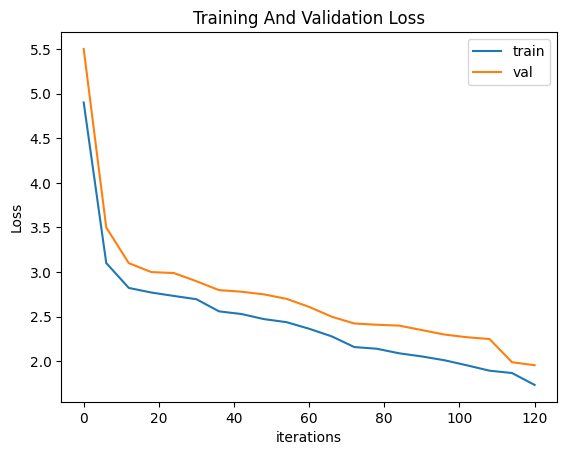

In [60]:
import matplotlib.pyplot as plt
import numpy as np


val_losses = []
train_losses = [4.90,3.1016,2.8224,2.7708,2.7326,2.6960,2.56,2.53,2.47295,2.4387,2.3650,2.28,2.16,2.141168,2.0897,2.05480,2.0122,1.9553,1.8953,1.8689,1.7358]
val_losses = [5.5,3.5,3.1,3,2.9892,2.8976,2.7980,2.78,2.75,2.70,2.61,2.5,2.4240,2.41,2.40,2.35,2.30,2.27,2.25,1.9897,1.9567]
x = np.arange(0, 126, 6)

fig, ax = plt.subplots()
ax.plot(x,train_losses,label="train")
ax.plot(x,val_losses,label="val")
ax.legend()

ax.set_xlabel("iterations")
ax.set_ylabel("Loss")
ax.set_title('Training And Validation Loss')

plt.show()